Importing required libraries

In [1]:
import os
Root = "D:\German TSRS Dataset"
os.chdir(Root)
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

Assigning path for dataset

In [2]:
data_dir = "D:\German TSRS Dataset"
train_path = 'Train'
test_path = 'Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

Finding total classes

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits',
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Visualizing The Dataset

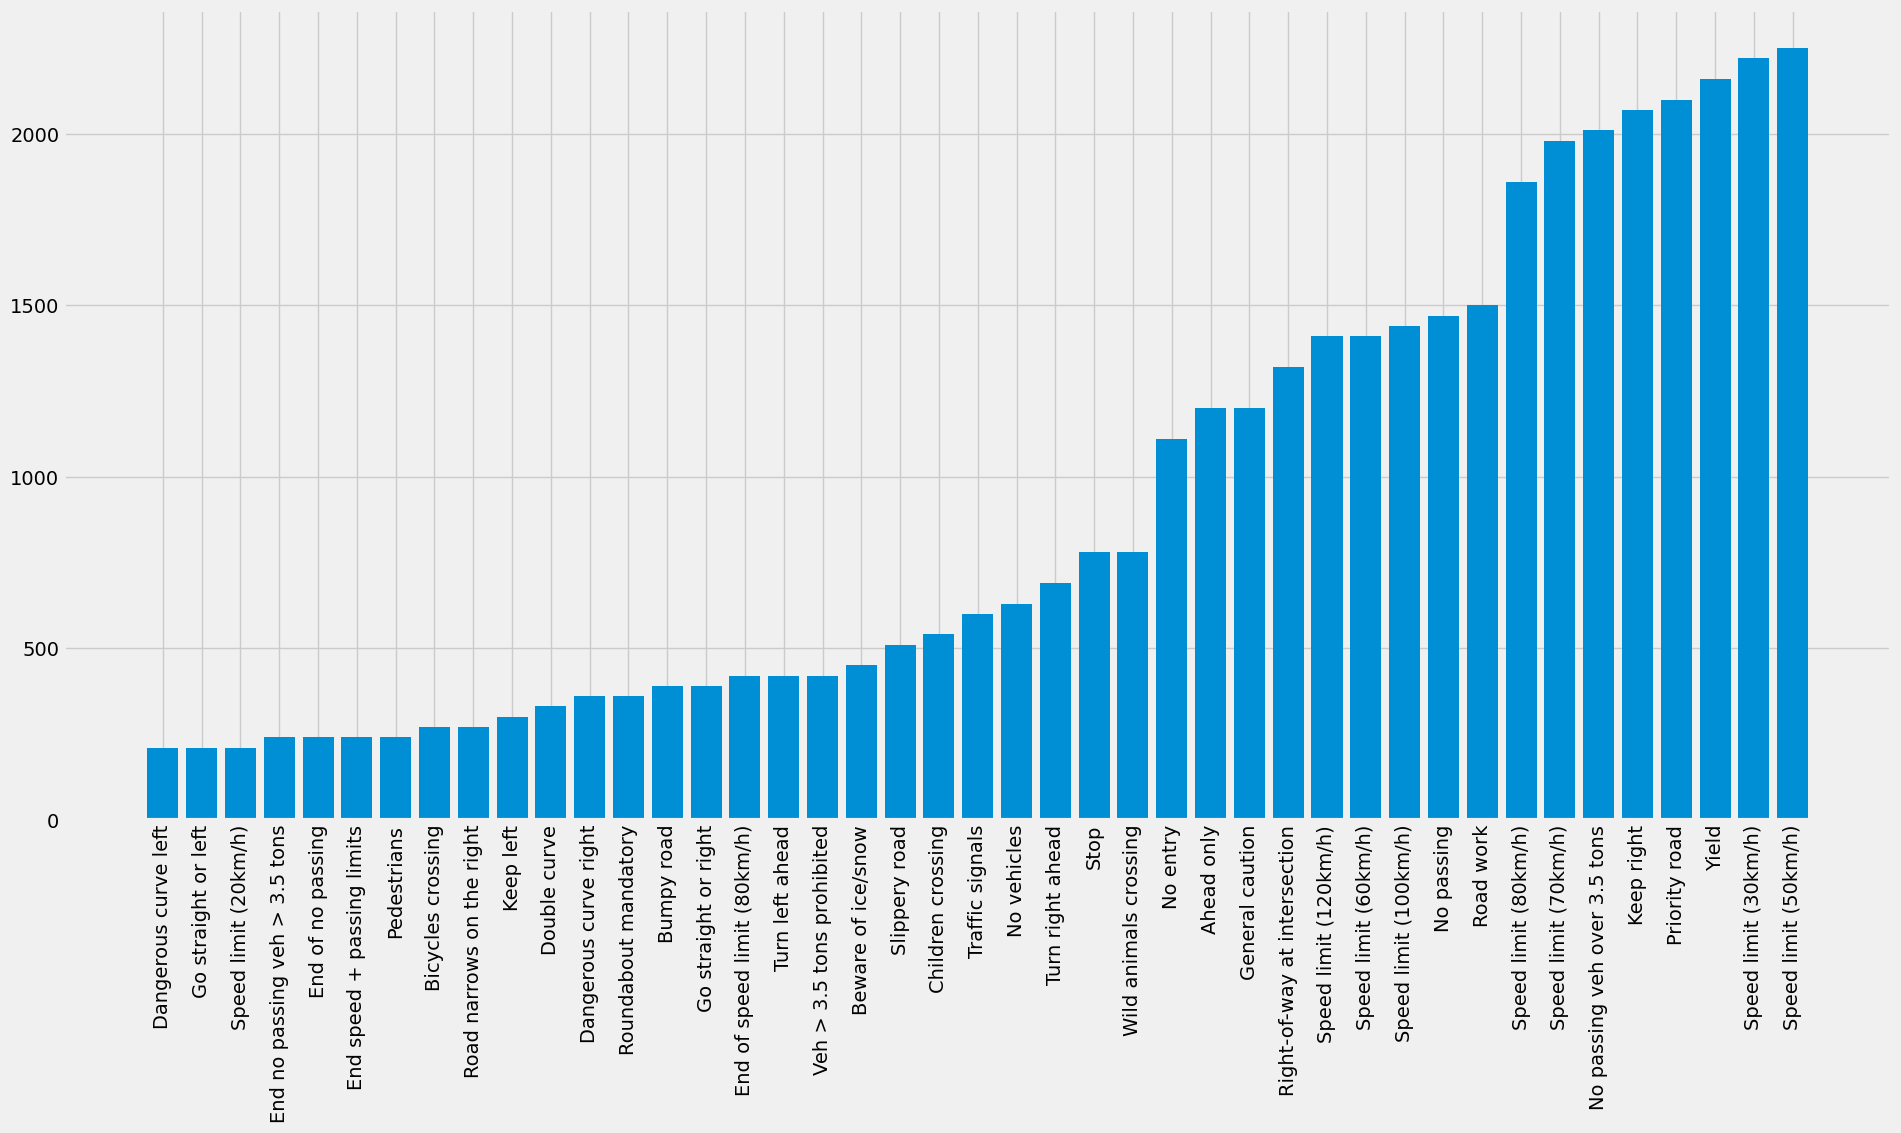

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

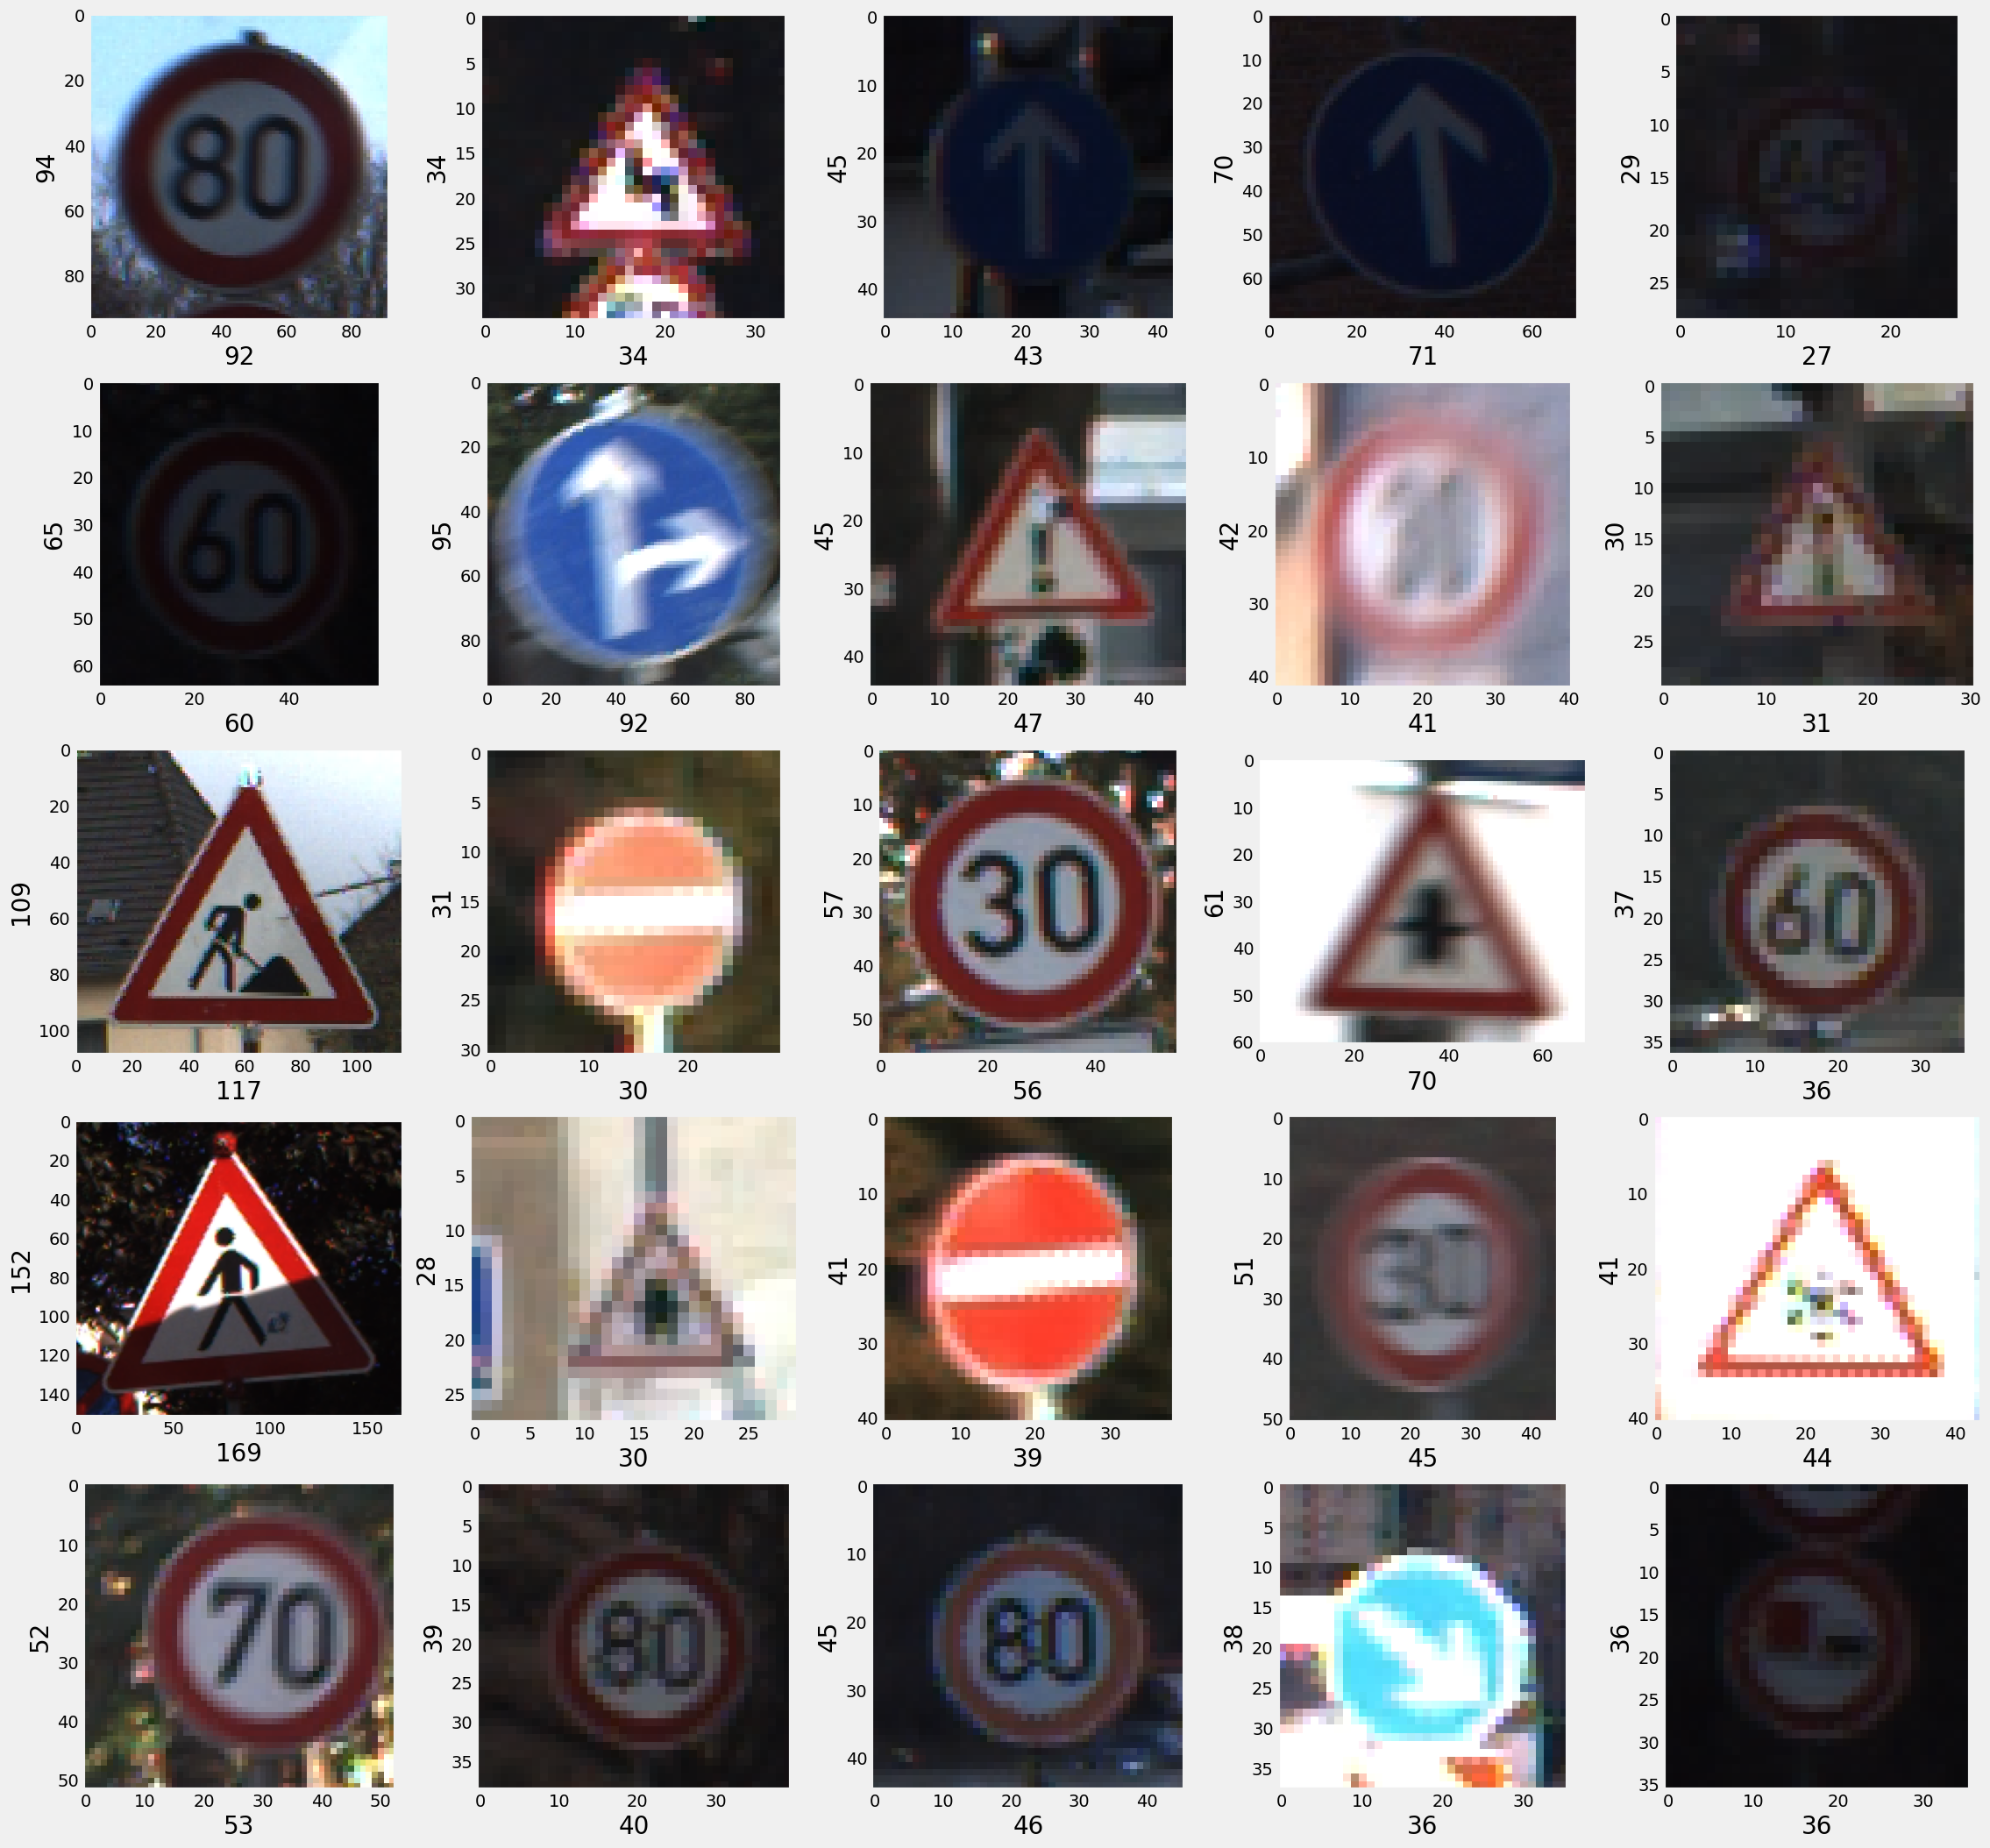

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

Collecting the Training Data

In [7]:
image_data = [] #This list will store the processed image data (as NumPy arrays) for each image in the training dataset.
image_labels = [] #This list will store the labels (integers representing traffic sign categories) corresponding to each image.

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


Shuffling the training data

In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

Splitting the data into train and validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


One hot encoding the labels

In [10]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


Making the model

In [12]:
model = keras.models.Sequential([  
    keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Hyperparameters
lr = 0.001
epochs = 30

# Define the optimizer without decay
opt = Adam(learning_rate=lr)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Define the learning rate decay function
def lr_decay(epoch):
    initial_lr = lr
    decay_rate = initial_lr / (epochs * 0.5)
    new_lr = initial_lr - epoch * decay_rate
    return new_lr if new_lr > 0 else 0.00001  # Ensures the learning rate doesn't go below a certain value

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)

# Fit the model (replace X_train, y_train, X_val, y_val with your data)
model.fit(X_train, y_train, epochs=epochs, callbacks=[lr_scheduler], batch_size=32, validation_data=(X_val, y_val))


Epoch 1/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.7311 - loss: 1.1306 - val_accuracy: 0.9804 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.9879 - loss: 0.0421 - val_accuracy: 0.9834 - val_loss: 0.0559 - learning_rate: 9.3333e-04
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.9947 - loss: 0.0205 - val_accuracy: 0.9901 - val_loss: 0.0318 - learning_rate: 8.6667e-04
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.9938 - loss: 0.0185 - val_accuracy: 0.9906 - val_loss: 0.0333 - learning_rate: 8.0000e-04
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.9956 - loss: 0.0154 - val_accuracy: 0.9965 - val_loss: 0.0109 - learning_rate: 7.3333e-04
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.9987 - loss: 0.0054 - val_accuracy: 0.9904 - val_loss: 0.0311 - learning_rate: 6.6667e-04
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - 

Augmenting the data and training the model

In [15]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.9632 - loss: 0.1256 - val_accuracy: 0.9991 - val_loss: 0.0032
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.9666 - loss: 0.1150 - val_accuracy: 0.9991 - val_loss: 0.0032
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - accuracy: 0.9679 - loss: 0.1128 - val_accuracy: 0.9991 - val_loss: 0.0033
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.9679 - loss: 0.1056 - val_accuracy: 0.9991 - val_loss: 0.0030
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.9707 - loss: 0.0990 - val_accuracy: 0.9991 - val_loss: 0.0032
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.9713 - loss: 0.1001 - val_accuracy: 0.9991 - val_loss: 0.0031
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.9692 - loss: 0.1058 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - accuracy: 0.9700 - loss: 0.1002 - 

In [16]:
import os

# Define the new directory where you want to save the model
new_directory = r"D:\ML_proj(1)\model"  # Your specified path

# Make sure the directory exists, create it if it doesn't
if not os.path.exists(new_directory):
    os.makedirs(new_directory)

# Save the model
model.save(os.path.join(new_directory, "model.keras"))


In [17]:
import os

output_dir = r"D:\ML_proj(1)\output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_weights(r"D:\ML_proj(1)\output\model_weights.weights.h5")

In [18]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api_export_path',
 '_api_export_symbol_id',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize'

Evaluating the model

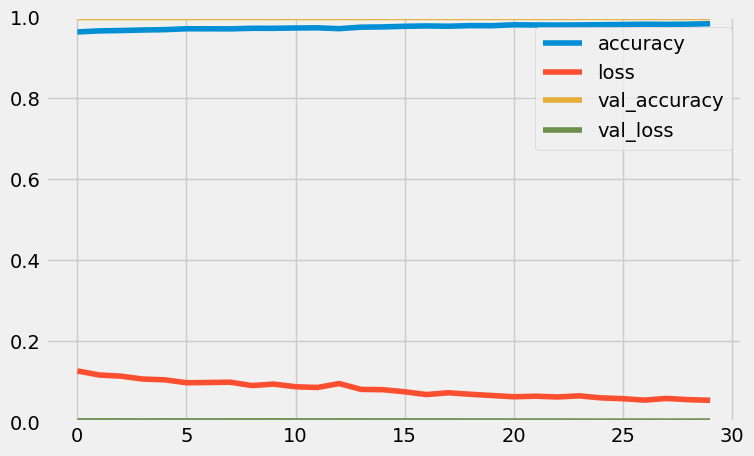

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Loading the test data and running the predictions

In [20]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score

# Set image dimensions for your model (use 30x30 if that's what your model expects)
IMG_HEIGHT, IMG_WIDTH = 30, 30  # Update as necessary

# Read test data
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except Exception as e:
        print("Error in " + img + ": " + str(e))

# Convert to numpy array
X_test = np.array(data)
X_test = X_test / 255.0  # Normalize the images

# Make predictions directly with the original shape
pred_probabilities = model.predict(X_test)

# Convert probabilities to class labels
pred = np.argmax(pred_probabilities, axis=1)

# Calculate accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred) * 100)


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Test Data accuracy:  98.79651623119557


Visualizing the confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

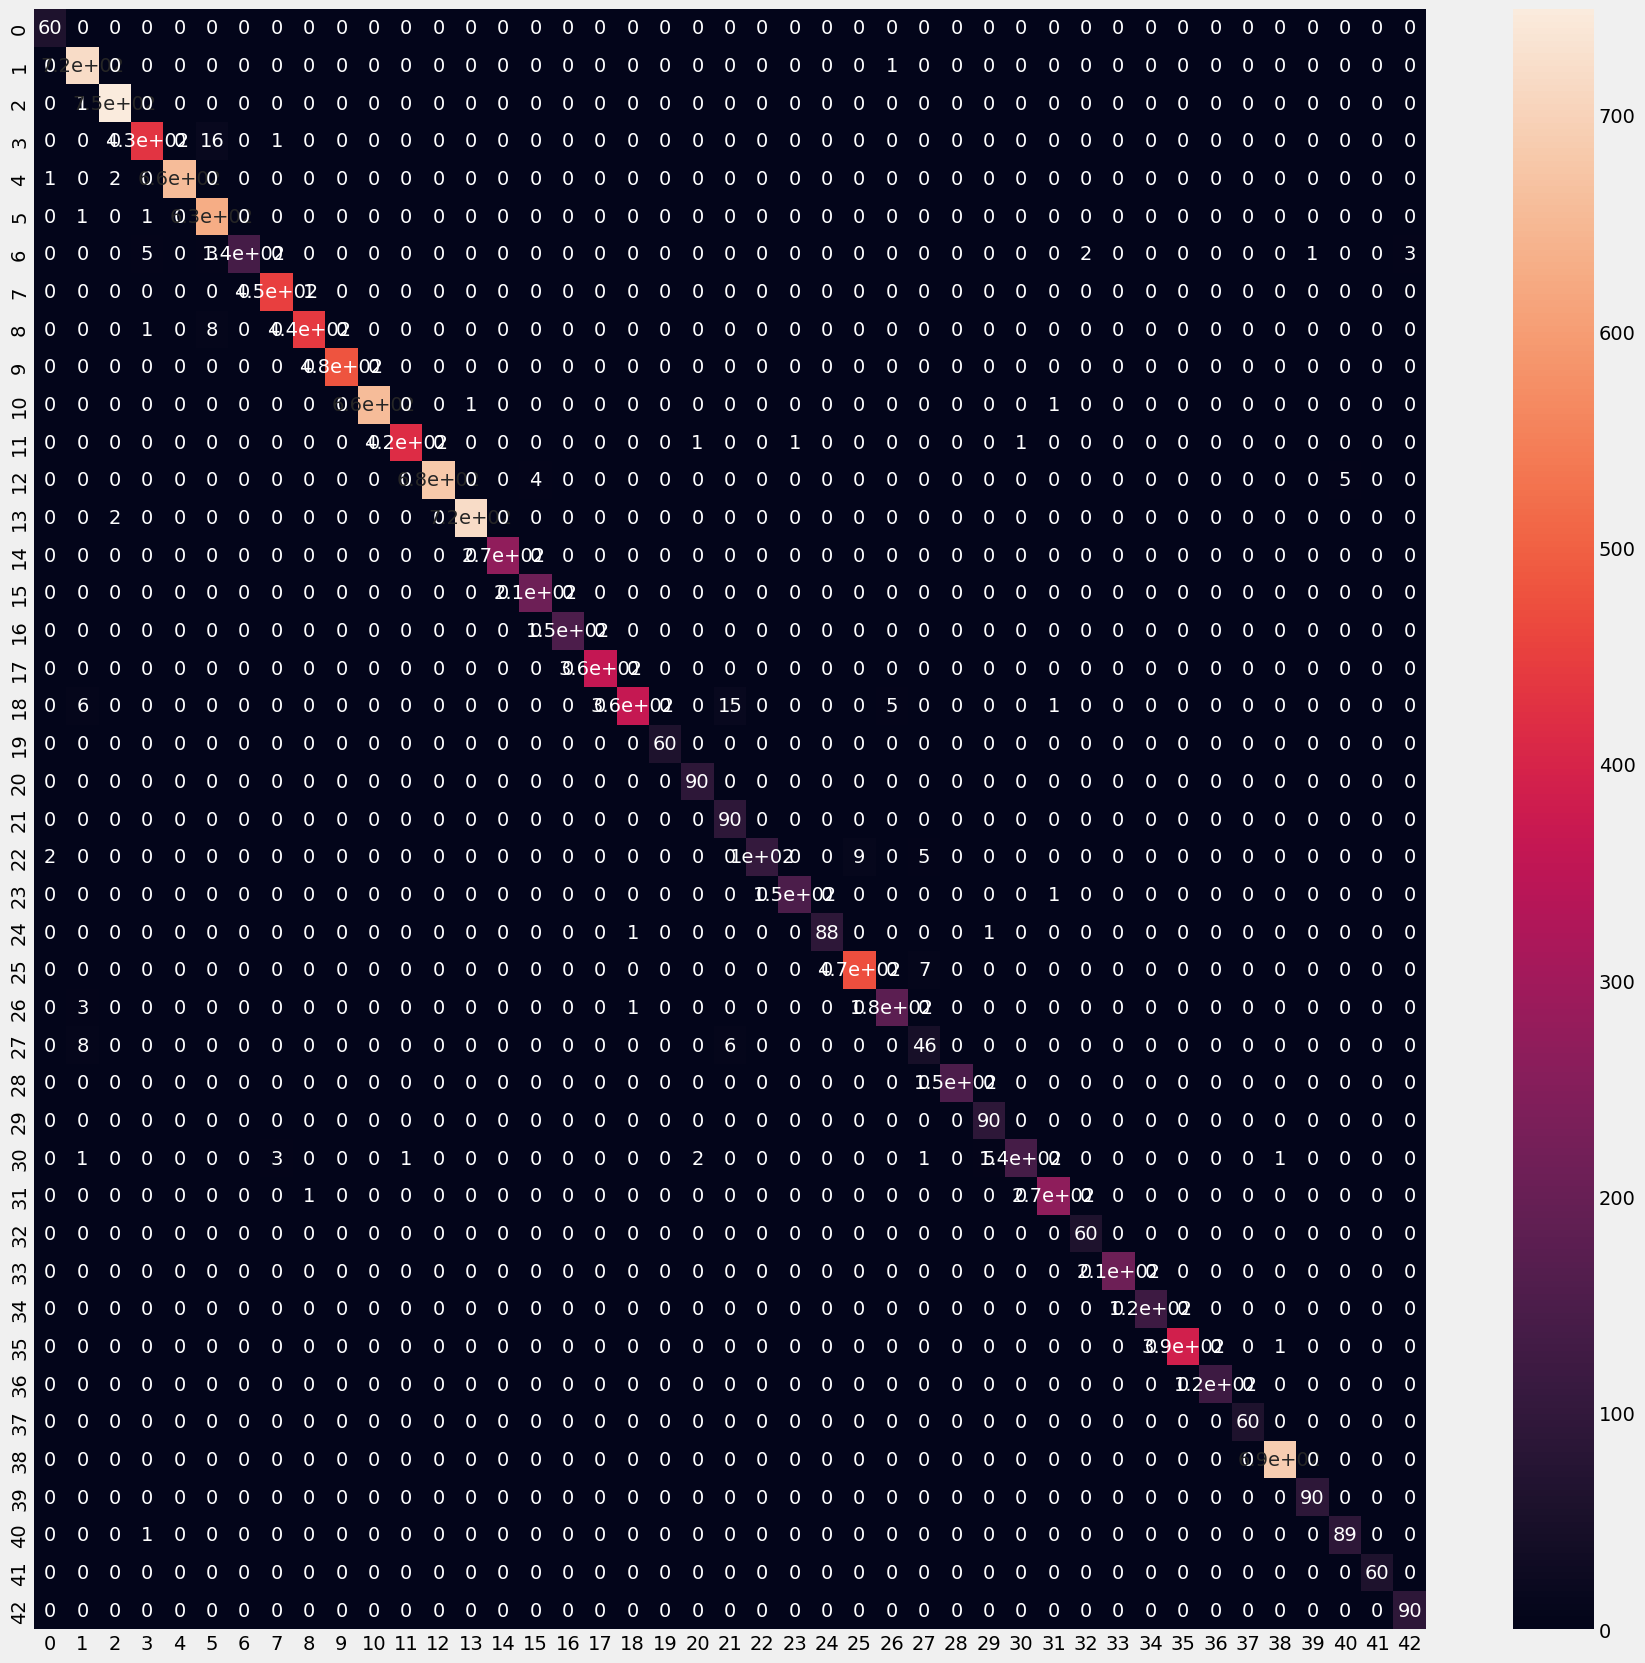

In [22]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Classification report

In [23]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.97      1.00      0.99       720
           2       0.99      1.00      1.00       750
           3       0.98      0.96      0.97       450
           4       1.00      1.00      1.00       660
           5       0.96      1.00      0.98       630
           6       1.00      0.91      0.95       150
           7       0.99      1.00      0.99       450
           8       1.00      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      0.99      1.00       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

Predictions on Test Data

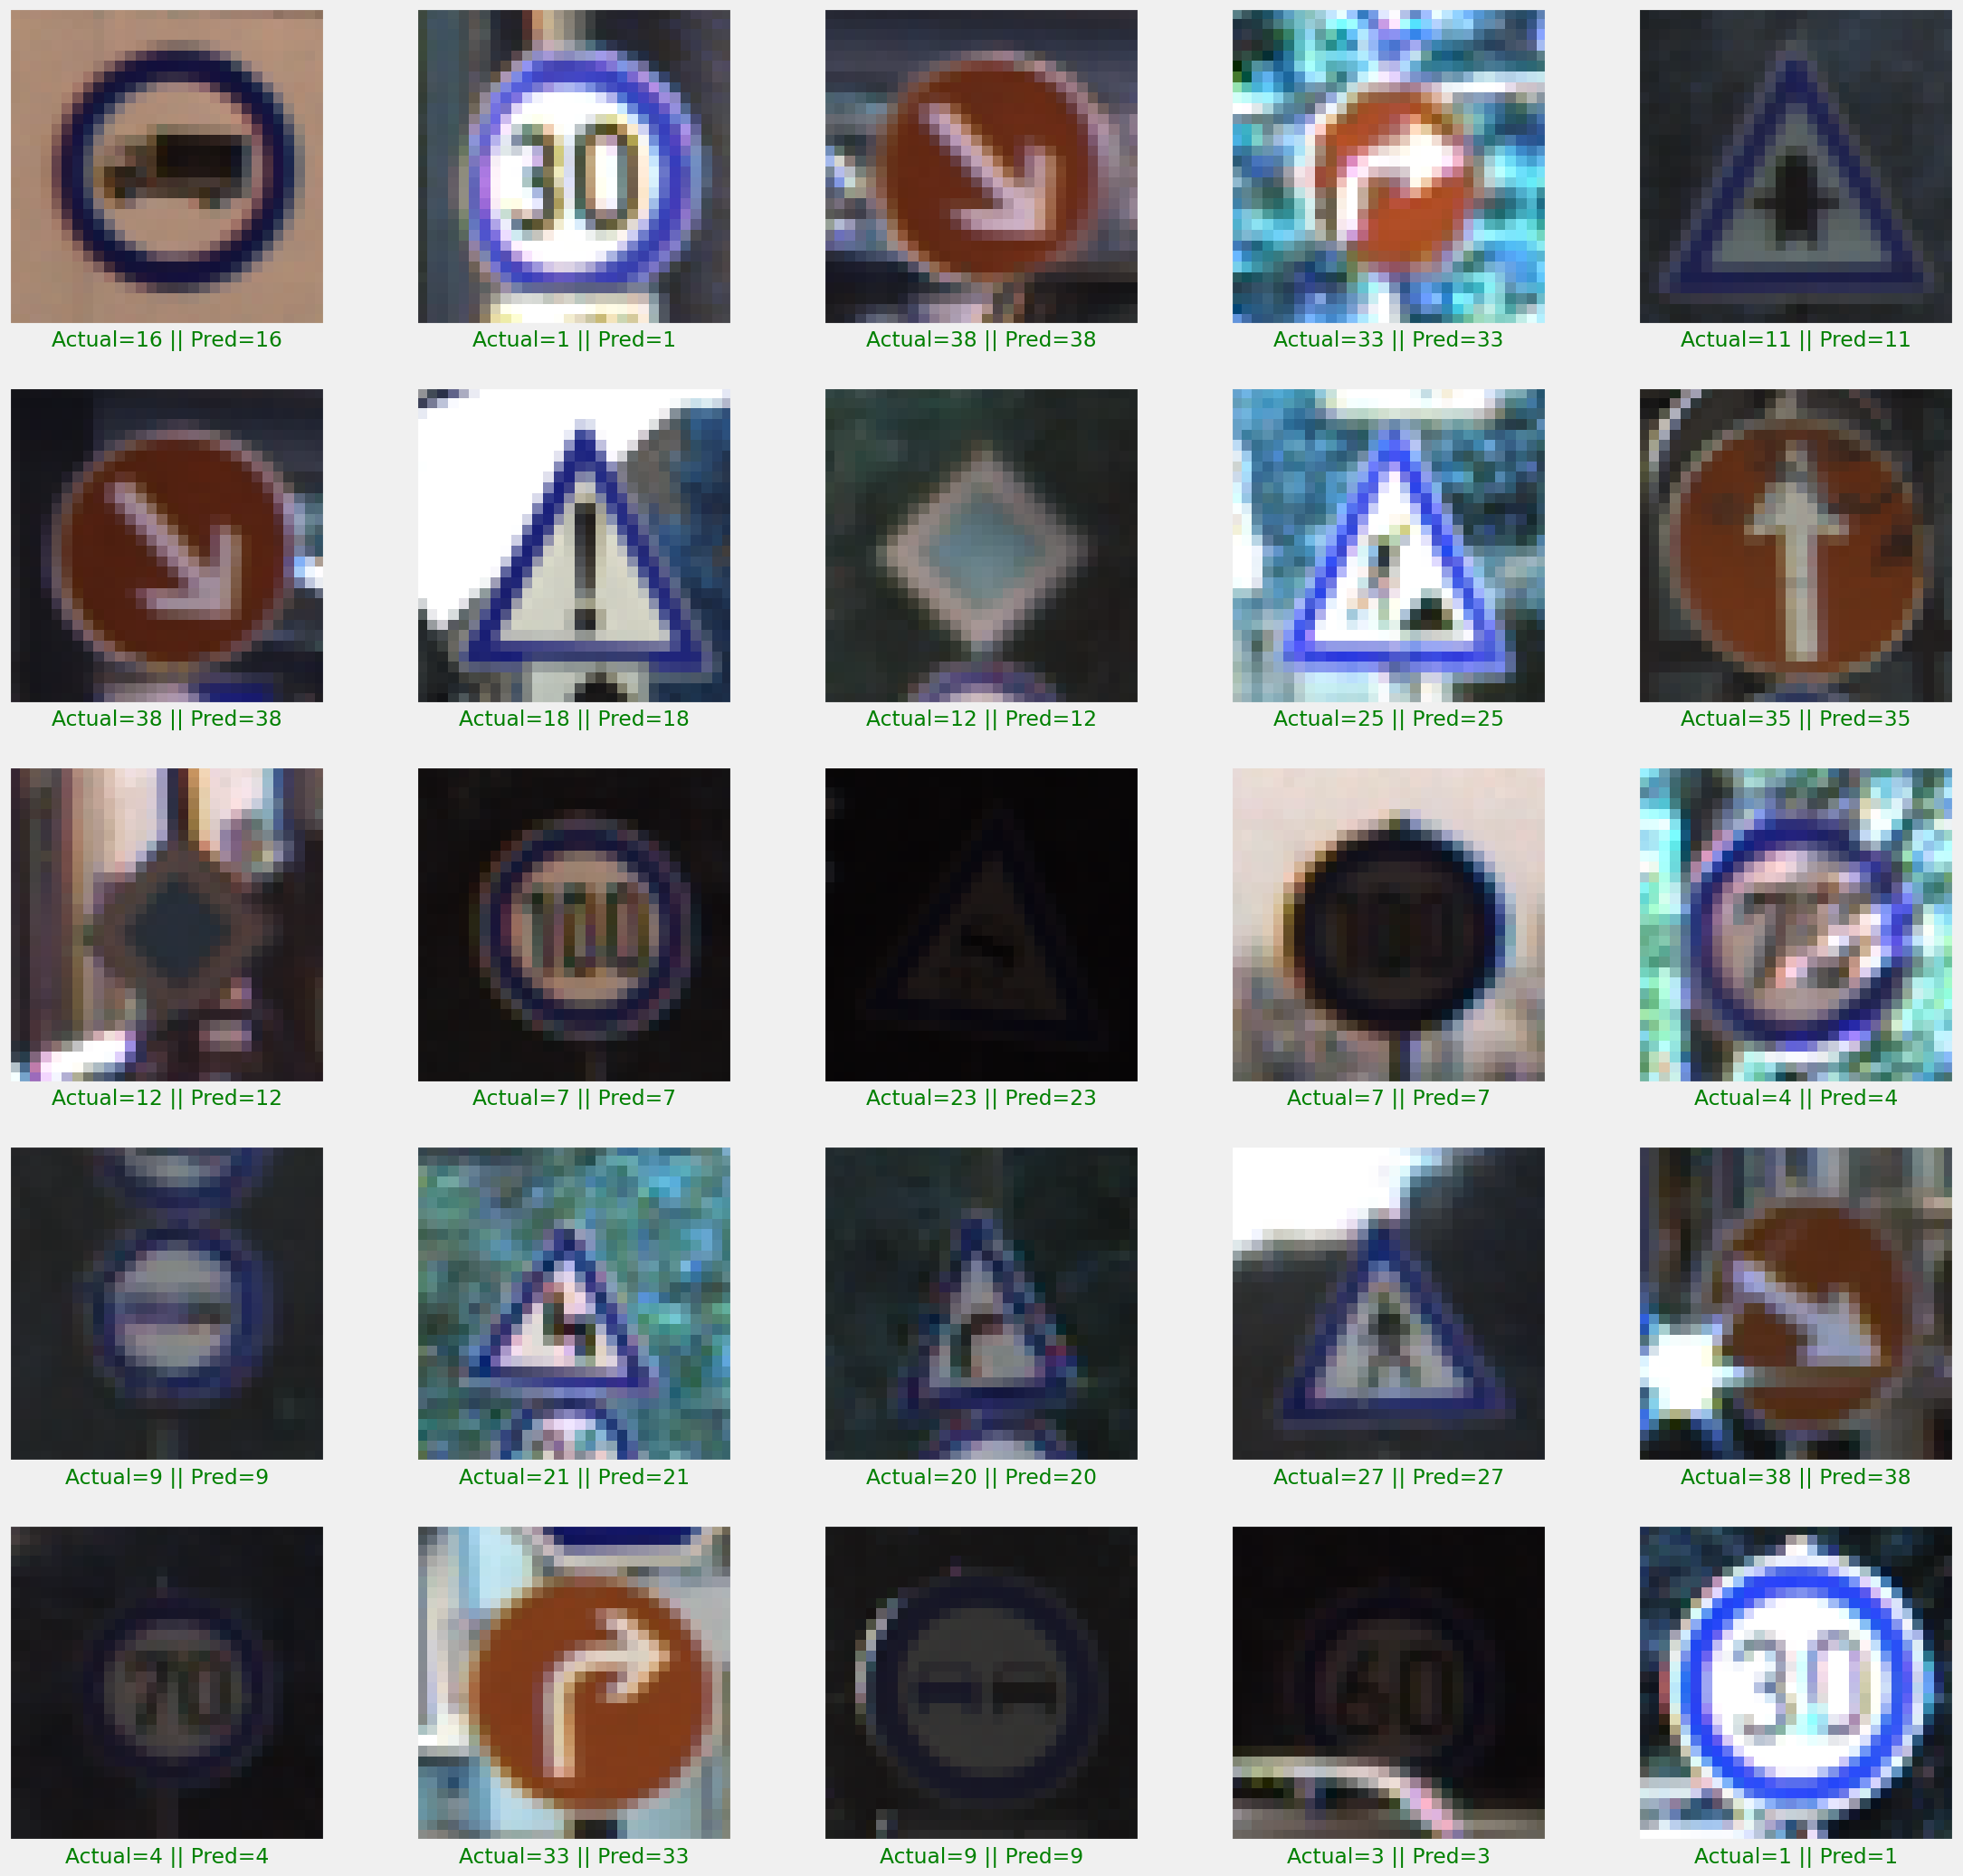

In [24]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [25]:
ls

 Volume in drive D has no label.
 Volume Serial Number is D496-F974

 Directory of D:\German TSRS Dataset

29-09-2024  10:39 AM    <DIR>          .
13-09-2024  11:02 PM    <DIR>          Meta
13-09-2024  11:02 PM             1,033 Meta.csv
13-09-2024  11:11 PM    <DIR>          Test
13-09-2024  11:02 PM           427,897 Test.csv
14-09-2024  12:02 AM    <DIR>          Train
13-09-2024  11:13 PM         1,940,896 Train.csv
               3 File(s)      2,369,826 bytes
               4 Dir(s)  277,701,480,448 bytes free


In [3]:
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
import os

model_path = r"D:\ML_proj(1)\model\model.keras"  # Use raw string for paths

if os.path.exists(model_path):
    loaded_model = tf.keras.models.load_model(model_path)

    image_path = r"D:\German TSRS Dataset\Test\00003.png"  # Use raw string for paths
    print(f"Loading image from: {image_path}")  # Print the image path for debugging
    image = cv2.imread(image_path)

    if image is not None:  # Check if the image was loaded successfully
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        expand_input = np.expand_dims(resize_image, axis=0)
        input_data = np.array(expand_input)
        input_data = input_data / 255.0

        pred = loaded_model.predict(input_data)
        result = pred.argmax()
        print("Predicted class:", result)
    else:
        print(f"Error: Could not load image from {image_path}. Please check the file path.")
else:
    print(f"Model file not found: {model_path}")


Loading image from: D:\German TSRS Dataset\Test\00003.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Predicted class: 33
